In [ ]:
#######################################################################################
# Project "Developing predictive models for COVID-19 diagnosis in paediatric patients: 
#          A case study about the potentials of Machine Learning in Public Health"
#          By Anna Mas-Casadesús (https://github.com/amascasadesus)
#          July 2020
#
#          Notebook 5/6
#######################################################################################

### Import basic modules & datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import grid
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.graph_objs as go 
import plotly.offline as py
import plotly.tools as tls
import warnings
from warnings import simplefilter
warnings.filterwarnings('ignore')
simplefilter(action='ignore', category=FutureWarning)

In [2]:
Xsel_train = pd.read_csv('symptoms_paediatric_pp2_Xsel_train.csv')
ysel_train = pd.read_csv('symptoms_paediatric_pp2_ysel_train.csv')
Xsel_test = pd.read_csv('symptoms_paediatric_pp2_Xsel_test.csv')
ysel_test = pd.read_csv('symptoms_paediatric_pp2_ysel_test.csv')
Xsel_trainres = pd.read_csv('symptoms_paediatric_pp2_Xsel_trainres.csv')
ysel_trainres = pd.read_csv('symptoms_paediatric_pp2_ysel_trainres.csv')
Xsel_testres = pd.read_csv('symptoms_paediatric_pp2_Xsel_testres.csv')
ysel_testres = pd.read_csv('symptoms_paediatric_pp2_ysel_testres.csv')
# Create checkpoints:
Xsel_train = Xsel_train.copy()
ysel_train = ysel_train.copy()
Xsel_test = Xsel_test.copy()
ysel_test = ysel_test.copy()
Xsel_trainres = Xsel_trainres.copy()
ysel_trainres = ysel_trainres.copy()
Xsel_testres = Xsel_testres.copy()
ysel_testres = ysel_testres.copy()

### Global Surrogate Method

A key issue that arises, especially as model complexity (and accuracy) increases, is interpretability. Interpretation of a machine learning model is the process wherein we try to understand the predictions of a machine learning model. However, some models are hard to interpret, such as Random Forest or Support Vector Machines.

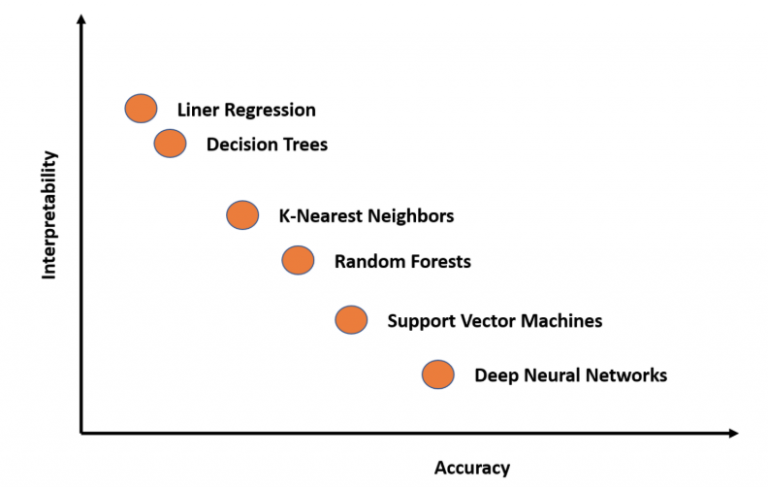


So how can we build interpretable machine learning models that don’t compromise on accuracy? One idea is to use simpler models. That way you can ensure you have full confidence in the interpretability. However, complex models can provide much better performance. So is there a way we can have some level of interpretability for black-box models as well? Yes! We do this through model agnostic techniques.

The **Global Surrogate Method** is a model agnostic method is an interpretable model that is trained to approximate the predictions of a black-box model (i.e. a non-interpretable model). For example, we could interpret a Random Forest classifier using a simple Decision Tree to explain its predictions. This is done by training a Decision Tree on the predictions of the Random Forest in this case. 

Here is a step-by-step breakdown to understand how a global surrogate model works:

 - We get predictions from the black-box model
 - Next, we select an interpretable model (Linear, decision tree, etc.)
 - We train an interpretable model on the original dataset and use black box predictions as the target
 - Measure the performance of the surrogate model
 - Finally, we interpret the surrogate model to understand how the black-box model is making its decisions


Reference:

* https://www.analyticsvidhya.com/blog/2019/08/decoding-black-box-step-by-step-guide-interpretable-machine-learning-models-python/?utm_source=blog&utm_medium=decision-tree-vs-random-forest-algorithm

#### RF definition

 - **Oversampled Model** best parameters = {'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}
 - **Original Model** best parameters = {'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 8}

In [3]:
# Oversampled data - Oversampled model parameters · OVERSAMPLED model (OV)
from sklearn.ensemble import RandomForestClassifier
rfmodel_ov = RandomForestClassifier(criterion='gini',
                                    max_depth=2,
                                    min_samples_leaf=2,
                                    min_samples_split=2,
                                    random_state=42)
rfmodel_ov.fit(Xsel_trainres, ysel_trainres)

RandomForestClassifier(max_depth=2, min_samples_leaf=2, random_state=42)

In [4]:
# Original data - Original model parameters · ORIGINAL model (OR)
rfmodel_or = RandomForestClassifier(criterion='entropy',
                                    max_depth=3,
                                    min_samples_leaf=3,
                                    min_samples_split=8,
                                    random_state=42)
rfmodel_or.fit(Xsel_train, ysel_train)

RandomForestClassifier(criterion='entropy', max_depth=3, min_samples_leaf=3,
                       min_samples_split=8, random_state=42)

#### RF predictions

In [5]:
# OV predictions 
yselrf_trainres = rfmodel_ov.predict(Xsel_trainres)

In [6]:
# OR predictions 
yselrf_train = rfmodel_or.predict(Xsel_train)

#### DT definition

In [7]:
# OV decision tree
from sklearn.tree import DecisionTreeClassifier
dtmodel_ov = DecisionTreeClassifier(random_state=42)
dtmodel_ov.fit(Xsel_trainres, yselrf_trainres)

DecisionTreeClassifier(random_state=42)

In [8]:
# OR decision tree
dtmodel_or = DecisionTreeClassifier(random_state=42)
dtmodel_or.fit(Xsel_train, yselrf_train)

DecisionTreeClassifier(random_state=42)

### Performance metrics

#### Function

In [9]:
def performance_metrics(model, X_train, y_train, X_test, y_test, train=True, cv=True):
    """
    Evaluates a classification model
    train = True to evaluate train subset, = False test subset
    cv = True performs stratified cross-validation
    """
    
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score 
    from sklearn.metrics import precision_score, recall_score, roc_auc_score
    from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold
    
    scoring = {'acc': 'accuracy',
               'prec_micro': 'precision_micro',
               'rec_micro': 'recall_micro',
               'f1_micro': 'f1_micro',
               'auc':'roc_auc'}
    
    if train==True:
        if cv==True:
            kfold=StratifiedKFold(n_splits=10, random_state=42)
            scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=kfold)
            ypredTrain = model.predict(X_train)
            Acc_train = scores['test_acc'].mean()
            Precision_train = scores['test_prec_micro'].mean()
            Recall_train = scores['test_rec_micro'].mean()
            F1_train = scores['test_f1_micro'].mean()
            AUC_train = scores['test_auc'].mean()
            conf_matrix_train = confusion_matrix(y_train, ypredTrain)
            class_report = classification_report(y_train, ypredTrain)
            print("TRAIN:\n===========================================")
            print(f"CV - Accuracy : {Acc_train:.2f}\n")
            print(f"CV - Precision: {Precision_train:.2f}\n")
            print(f"CV - Recall: {Recall_train:.2f}\n")
            print(f"CV - F1 score: {F1_train:.2f}\n")   
            print(f"CV - AUC score: {AUC_train:.2f}\n") 
            print(f"Confusion Matrix:\n {conf_matrix_train}\n")
            print(f"Classification Report:\n {class_report}\n")                 
        
        elif cv==False:
            scores = cross_validate(model, X_train, y_train, scoring=scoring)
            ypredTrain = model.predict(X_train)
            Acc_train = scores['test_acc'].mean()
            Precision_train = scores['test_prec_micro'].mean()
            Recall_train = scores['test_rec_micro'].mean()
            F1_train = scores['test_f1_micro'].mean()
            AUC_train = scores['test_auc'].mean()
            conf_matrix_train = confusion_matrix(y_train, ypredTrain)
            class_report = classification_report(y_train, ypredTrain)
            print("TRAIN:\n===========================================")
            print(f"CV - Accuracy : {Acc_train:.2f}\n")
            print(f"CV - Precision: {Precision_train:.2f}\n")
            print(f"CV - Recall: {Recall_train:.2f}\n")
            print(f"CV - F1 score: {F1_train:.2f}\n")   
            print(f"CV - AUC score: {AUC_train:.2f}\n")  
            print(f"Confusion Matrix:\n {conf_matrix_train}\n")
            print(f"Classification Report:\n {class_report}\n")
        
    elif train==False:
        if cv==True:
            kfold=StratifiedKFold(n_splits=10, random_state=42)
            scores = cross_validate(model, X_test, y_test, scoring=scoring, cv=kfold)
            ypredTest = model.predict(X_test)
            Acc_test = scores['test_acc'].mean()
            Precision_test = scores['test_prec_micro'].mean()
            Recall_test = scores['test_rec_micro'].mean()
            F1_test = scores['test_f1_micro'].mean()
            AUC_test = scores['test_auc'].mean()
            conf_matrix_test = confusion_matrix(y_test, ypredTest)
            class_report = classification_report(y_test, ypredTest)        
            print("TEST:\n===========================================")
            print(f"CV - Accuracy : {Acc_test:.2f}\n")
            print(f"CV - Precision: {Precision_test:.2f}\n")
            print(f"CV - Recall: {Recall_test:.2f}\n")
            print(f"CV - F1 score: {F1_test:.2f}\n")    
            print(f"CV - AUC score: {AUC_test:.2f}\n")   
            print(f"Confusion Matrix:\n {conf_matrix_test}\n")
            print(f"Classification Report:\n {class_report}\n")
           
        elif cv==False:
            scores = cross_validate(model, X_test, y_test, scoring=scoring)
            ypredTest = model.predict(X_test)
            Acc_test = scores['test_acc'].mean()
            Precision_test = scores['test_prec_micro'].mean()
            Recall_test = scores['test_rec_micro'].mean()
            F1_test = scores['test_f1_micro'].mean()
            AUC_test = scores['test_auc'].mean()
            conf_matrix_test = confusion_matrix(y_test, ypredTest)
            class_report = classification_report(y_test, ypredTest)        
            print("TEST:\n===========================================")
            print(f"CV - Accuracy : {Acc_test:.2f}\n")
            print(f"CV - Precision: {Precision_test:.2f}\n")
            print(f"CV - Recall: {Recall_test:.2f}\n")
            print(f"CV - F1 score: {F1_test:.2f}\n")    
            print(f"CV - AUC score: {AUC_test:.2f}\n")   
            print(f"Confusion Matrix:\n {conf_matrix_test}\n")
            print(f"Classification Report:\n {class_report}\n")    

#### OV model

In [10]:
# OV train
print('Oversampled Model\n')
print(performance_metrics(dtmodel_ov, Xsel_trainres, yselrf_trainres, Xsel_test, ysel_test, train=True, cv=True))

Oversampled Model

TRAIN:
CV - Accuracy : 0.98

CV - Precision: 0.98

CV - Recall: 0.98

CV - F1 score: 0.98

CV - AUC score: 0.97

Confusion Matrix:
 [[44  0]
 [ 0 44]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        44

    accuracy                           1.00        88
   macro avg       1.00      1.00      1.00        88
weighted avg       1.00      1.00      1.00        88


None


In [11]:
# OV test
print('Oversampled Model\n')
print(performance_metrics(dtmodel_ov, Xsel_trainres, yselrf_trainres, Xsel_test, ysel_test, train=False, cv=False))

Oversampled Model

TEST:
CV - Accuracy : 0.69

CV - Precision: 0.69

CV - Recall: 0.69

CV - F1 score: 0.69

CV - AUC score: 0.52

Confusion Matrix:
 [[17  6]
 [ 4  2]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.74      0.77        23
           1       0.25      0.33      0.29         6

    accuracy                           0.66        29
   macro avg       0.53      0.54      0.53        29
weighted avg       0.69      0.66      0.67        29


None


#### OR model

In [12]:
# OR train
print('Original Model\n')
print(performance_metrics(dtmodel_or, Xsel_train, yselrf_train, Xsel_test, ysel_test, train=True, cv=False))

Original Model

TRAIN:
CV - Accuracy : 0.88

CV - Precision: 0.88

CV - Recall: 0.88

CV - F1 score: 0.88

CV - AUC score: 0.73

Confusion Matrix:
 [[48  0]
 [ 0  9]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00         9

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57


None


In [13]:
# OR test
print('Original Model\n')
print(performance_metrics(dtmodel_or, Xsel_train, yselrf_train, Xsel_test, ysel_test, train=False, cv=False))

Original Model

TEST:
CV - Accuracy : 0.69

CV - Precision: 0.69

CV - Recall: 0.69

CV - F1 score: 0.69

CV - AUC score: 0.52

Confusion Matrix:
 [[21  2]
 [ 5  1]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.91      0.86        23
           1       0.33      0.17      0.22         6

    accuracy                           0.76        29
   macro avg       0.57      0.54      0.54        29
weighted avg       0.71      0.76      0.73        29


None


#### PJ model

Although oversampling of the test subset is not advised (see notebook *2. Data Pre-Processing II*), given the small size of our sample, we will apply the technique on this subset to observe how a theoretical "Projected Model" (with a bigger sample) might behave.

In [14]:
# PJ test
print('Projected Model\n')
print(performance_metrics(dtmodel_ov, Xsel_trainres, yselrf_trainres, Xsel_testres, ysel_testres, train=False, cv=True))

Projected Model

TEST:
CV - Accuracy : 0.83

CV - Precision: 0.83

CV - Recall: 0.83

CV - F1 score: 0.83

CV - AUC score: 0.82

Confusion Matrix:
 [[17  6]
 [13 10]]

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.74      0.64        23
           1       0.62      0.43      0.51        23

    accuracy                           0.59        46
   macro avg       0.60      0.59      0.58        46
weighted avg       0.60      0.59      0.58        46


None


### Performance figures

#### Functions

In [15]:
# Precision/Recall Curve · OV
def pr_curve_ov(model, X_train, y_train, X_test, y_test, train=True):
    """
    Plots a precision/recall curve of a given classification model
    train = True to evaluate train subset, = False test subset
    """
    from sklearn.metrics import precision_recall_curve
    if train==True:
        ypredTrain = model.predict(X_train)   
        precisions, recalls, thresholds = precision_recall_curve(y_train, ypredTrain)
        plt.plot(precisions, recalls, linewidth=3, color='r', linestyle='-')
        plt.rc('xtick', labelsize=10)    
        plt.rc('ytick', labelsize=10)  
        plt.xlabel("Precision", size=12)
        plt.ylabel("Recall", size=12)
        plt.grid()
        plt.rcParams['figure.facecolor'] = '#F2F3F4'            
        plt.rcParams['axes.facecolor'] = '#F2F3F4'                           
        plt.title("PR Curve: Precision/Recall Trade-off\n\n(Oversampled Model: Train)\n", size=14)          
        plt.show()
    elif train==False:
        ypredTest = model.predict(X_test)
        precisions, recalls, thresholds = precision_recall_curve(y_test, ypredTest)
        plt.plot(precisions, recalls, linewidth=3, color='b', linestyle='-')
        plt.rc('xtick', labelsize=10)    
        plt.rc('ytick', labelsize=10)  
        plt.xlabel("Precision", size=12)
        plt.ylabel("Recall", size=12)
        plt.grid()
        plt.rcParams['figure.facecolor'] = '#F2F3F4'            
        plt.rcParams['axes.facecolor'] = '#F2F3F4'
        plt.title("PR Curve: Precision/Recall Trade-off\n\n(Oversampled Model: Test)\n", size=14)
        plt.show()

In [16]:
# Precision/Recall Curve · OR
def pr_curve_or(model, X_train, y_train, X_test, y_test, train=True): 
    """
    Plots a precision/recall curve of a given classification model
    train = True to evaluate train subset, = False test subset
    """
    from sklearn.metrics import precision_recall_curve
    if train==True:
        ypredTrain = model.predict(X_train)   
        precisions, recalls, thresholds = precision_recall_curve(y_train, ypredTrain)
        plt.plot(precisions, recalls, linewidth=3, color='r', linestyle=':')
        plt.rc('xtick', labelsize=10)    
        plt.rc('ytick', labelsize=10)  
        plt.xlabel("Precision", size=12)
        plt.ylabel("Recall", size=12)
        plt.grid()
        plt.rcParams['figure.facecolor'] = '#F2F3F4'            
        plt.rcParams['axes.facecolor'] = '#F2F3F4'                           
        plt.title("PR Curve: Precision/Recall Trade-off\n\n(Original Model: Train)\n", size=14)          
        plt.show()
    elif train==False:
        ypredTest = model.predict(X_test)
        precisions, recalls, thresholds = precision_recall_curve(y_test, ypredTest)
        plt.plot(precisions, recalls, linewidth=3, color='b', linestyle=':')
        plt.rc('xtick', labelsize=10)    
        plt.rc('ytick', labelsize=10)  
        plt.xlabel("Precision", size=12)
        plt.ylabel("Recall", size=12)
        plt.grid()
        plt.rcParams['figure.facecolor'] = '#F2F3F4'            
        plt.rcParams['axes.facecolor'] = '#F2F3F4'
        plt.title("PR Curve: Precision/Recall Trade-off\n\n(Original Model: Test)\n", size=14)
        plt.show()

In [17]:
# Precision/Recall Curve · PJ
def pr_curve_pj(model, X_train, y_train, X_test, y_test, train=True): 
    """
    Plots a precision/recall curve of a given classification model
    train = True to evaluate train subset, = False test subset
    """
    from sklearn.metrics import precision_recall_curve
    if train==True:
        ypredTrain = model.predict(X_train)   
        precisions, recalls, thresholds = precision_recall_curve(y_train, ypredTrain)
        plt.plot(precisions, recalls, linewidth=3, color='r', linestyle='-.')
        plt.rc('xtick', labelsize=10)    
        plt.rc('ytick', labelsize=10)  
        plt.xlabel("Precision", size=12)
        plt.ylabel("Recall", size=12)
        plt.grid()
        plt.rcParams['figure.facecolor'] = '#F2F3F4'            
        plt.rcParams['axes.facecolor'] = '#F2F3F4'                           
        plt.title("PR Curve: Precision/Recall Trade-off\n\n(Projected Model: Train)\n", size=14)          
        plt.show()
    elif train==False:
        ypredTest = model.predict(X_test)
        precisions, recalls, thresholds = precision_recall_curve(y_test, ypredTest)
        plt.plot(precisions, recalls, linewidth=3, color='b', linestyle='-.')
        plt.rc('xtick', labelsize=10)    
        plt.rc('ytick', labelsize=10)  
        plt.xlabel("Precision", size=12)
        plt.ylabel("Recall", size=12)
        plt.grid()
        plt.rcParams['figure.facecolor'] = '#F2F3F4'            
        plt.rcParams['axes.facecolor'] = '#F2F3F4'
        plt.title("PR Curve: Precision/Recall Trade-off\n\n(Projected Model: Test)\n", size=14)
        plt.show()

In [18]:
# ROC Curve · OV
def roc_curve_ov(model, X_train, y_train, X_test, y_test, train=True):  
    """
    Plots a ROC curve of a given classification model
    train = True to evaluate train subset, = False test subset
    """
    from sklearn.metrics import roc_curve
    if train==True:
        ypredTrain = model.predict(X_train)
        fpr, tpr, thresholds = roc_curve(y_train, ypredTrain)
        plt.plot(fpr, tpr, linewidth=3, label=None, color='r', linestyle='-')
        plt.rc('xtick', labelsize=10)    
        plt.rc('ytick', labelsize=10)  
        plt.xlabel('False Positive Rate', size=12)
        plt.ylabel('True Positive Rate', size=12)
        plt.grid()
        plt.rcParams['figure.facecolor'] = '#F2F3F4'            
        plt.rcParams['axes.facecolor'] = '#F2F3F4'  
        plt.title("ROC Curve: Sensitivity/Specificity Trade-off\n\n(Oversampled Model: Train)\n", size=14)
        plt.show()
    elif train==False:
        ypredTest = model.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, ypredTest)
        plt.plot(fpr, tpr, linewidth=3, label=None, color='b', linestyle='-')
        plt.rc('xtick', labelsize=10)    
        plt.rc('ytick', labelsize=10)  
        plt.xlabel('False Positive Rate', size=12)
        plt.ylabel('True Positive Rate', size=12)
        plt.grid()
        plt.rcParams['figure.facecolor'] = '#F2F3F4'            
        plt.rcParams['axes.facecolor'] = '#F2F3F4'
        plt.title('ROC Curve: Sensitivity/Specificity Trade-off\n\n(Oversampled Model: Test)\n', size=14)
        plt.show()

In [19]:
# ROC Curve · OR
def roc_curve_or(model, X_train, y_train, X_test, y_test, train=True):  
    """
    Plots a ROC curve of a given classification model
    train = True to evaluate train subset, = False test subset
    """
    from sklearn.metrics import roc_curve
    if train==True:
        ypredTrain = model.predict(X_train)
        fpr, tpr, thresholds = roc_curve(y_train, ypredTrain)
        plt.plot(fpr, tpr, linewidth=3, label=None, color='r', linestyle=':')
        plt.rc('xtick', labelsize=10)    
        plt.rc('ytick', labelsize=10)  
        plt.xlabel('False Positive Rate', size=12)
        plt.ylabel('True Positive Rate', size=12)
        plt.grid()
        plt.rcParams['figure.facecolor'] = '#F2F3F4'            
        plt.rcParams['axes.facecolor'] = '#F2F3F4'  
        plt.title("ROC Curve: Sensitivity/Specificity Trade-off\n\n(Original Model: Train)\n", size=14)
        plt.show()
    elif train==False:
        ypredTest = model.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, ypredTest)
        plt.plot(fpr, tpr, linewidth=3, label=None, color='b', linestyle=':')
        plt.rc('xtick', labelsize=10)    
        plt.rc('ytick', labelsize=10)  
        plt.xlabel('False Positive Rate', size=12)
        plt.ylabel('True Positive Rate', size=12)
        plt.grid()
        plt.rcParams['figure.facecolor'] = '#F2F3F4'            
        plt.rcParams['axes.facecolor'] = '#F2F3F4'
        plt.title('ROC Curve: Sensitivity/Specificity Trade-off\n\n(Original Model: Test)\n', size=14)
        plt.show()

In [20]:
# ROC Curve · PJ
def roc_curve_pj(model, X_train, y_train, X_test, y_test, train=True):
    """
    Plots a ROC curve of a given classification model
    train = True to evaluate train subset, = False test subset
    """
    from sklearn.metrics import roc_curve
    if train==True:
        ypredTrain = model.predict(X_train)
        fpr, tpr, thresholds = roc_curve(y_train, ypredTrain)
        plt.plot(fpr, tpr, linewidth=3, label=None, color='r', linestyle='-.')
        plt.rc('xtick', labelsize=10)    
        plt.rc('ytick', labelsize=10)  
        plt.xlabel('False Positive Rate', size=12)
        plt.ylabel('True Positive Rate', size=12)
        plt.grid()
        plt.rcParams['figure.facecolor'] = '#F2F3F4'            
        plt.rcParams['axes.facecolor'] = '#F2F3F4'  
        plt.title("ROC Curve: Sensitivity/Specificity Trade-off\n\n(Projected Model: Train)\n", size=14)
        plt.show()
    elif train==False:
        ypredTest = model.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, ypredTest)
        plt.plot(fpr, tpr, linewidth=3, label=None, color='b', linestyle='-.')
        plt.rc('xtick', labelsize=10)    
        plt.rc('ytick', labelsize=10)  
        plt.xlabel('False Positive Rate', size=12)
        plt.ylabel('True Positive Rate', size=12)
        plt.grid()
        plt.rcParams['figure.facecolor'] = '#F2F3F4'            
        plt.rcParams['axes.facecolor'] = '#F2F3F4'
        plt.title('ROC Curve: Sensitivity/Specificity Trade-off\n\n(Projected Model: Test)\n', size=14)
        plt.show()

In [21]:
# Confusion Matrix · OV
def conf_matrix_ov(model, X_train, y_train, X_test, y_test, train=True): 
    """
    Plots a confusion matrix of a given classification model
    train = True to evaluate train subset, = False test subset
    """
    from sklearn.metrics import confusion_matrix
    import itertools
    if train==True:    
        ypredTrain = model.predict(X_train)
        cm = confusion_matrix(y_train, ypredTrain)
        def plot_conf_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Reds):
            plt.figure(figsize = (5, 5))
            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title(title, size = 14)
            plt.colorbar(aspect=4)
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=0, size = 10)
            plt.yticks(tick_marks, classes, size = 10)
            fmt = 'd'
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], fmt), fontsize = 14,
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
                plt.grid(b=None)
            plt.tight_layout()
            plt.ylabel('True label', size = 12)
            plt.xlabel('Predicted label', size = 12)
        plot_conf_matrix(cm, classes = ['Covid-', 'Covid+'], 
                                  title = 'Confusion Matrix\n\n(Oversampled Model: Train)\n')
    elif train==False:
        ypredTest = model.predict(X_test)
        cm = confusion_matrix(y_test, ypredTest)
        def plot_conf_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
            plt.figure(figsize = (5, 5))
            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title(title, size = 14)
            plt.colorbar(aspect=4)
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=0, size = 10)
            plt.yticks(tick_marks, classes, size = 10)
            fmt = 'd'
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], fmt), fontsize = 14,
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
                plt.grid(b=None)
            plt.tight_layout()
            plt.ylabel('True label', size = 12)
            plt.xlabel('Predicted label', size = 12)
        plot_conf_matrix(cm, classes = ['Covid-', 'Covid+'], 
                                  title = 'Confusion Matrix\n\n(Oversampled Model: Test)\n')  

In [22]:
# Confusion Matrix · OR
def conf_matrix_or(model, X_train, y_train, X_test, y_test, train=True): 
    """
    Plots a confusion matrix of a given classification model
    train = True to evaluate train subset, = False test subset
    """
    from sklearn.metrics import confusion_matrix
    import itertools
    if train==True:    
        ypredTrain = model.predict(X_train)
        cm = confusion_matrix(y_train, ypredTrain)
        def plot_conf_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Reds):
            plt.figure(figsize = (5, 5))
            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title(title, size = 14)
            plt.colorbar(aspect=4)
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=0, size = 10)
            plt.yticks(tick_marks, classes, size = 10)
            fmt = 'd'
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], fmt), fontsize = 14,
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
                plt.grid(b=None)
            plt.tight_layout()
            plt.ylabel('True label', size = 12)
            plt.xlabel('Predicted label', size = 12)
        plot_conf_matrix(cm, classes = ['Covid-', 'Covid+'], 
                                  title = 'Confusion Matrix\n\n(Original Model: Train)\n')
    elif train==False:
        ypredTest = model.predict(X_test)
        cm = confusion_matrix(y_test, ypredTest)
        def plot_conf_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
            plt.figure(figsize = (5, 5))
            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title(title, size = 14)
            plt.colorbar(aspect=4)
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=0, size = 10)
            plt.yticks(tick_marks, classes, size = 10)
            fmt = 'd'
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], fmt), fontsize = 14,
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
                plt.grid(b=None)
            plt.tight_layout()
            plt.ylabel('True label', size = 12)
            plt.xlabel('Predicted label', size = 12)
        plot_conf_matrix(cm, classes = ['Covid-', 'Covid+'], 
                                  title = 'Confusion Matrix\n\n(Original Model: Test)\n')  

In [23]:
# Confusion Matrix · PJ
def conf_matrix_pj(model, X_train, y_train, X_test, y_test, train=True): 
    """
    Plots a confusion matrix of a given classification model
    train = True to evaluate train subset, = False test subset
    """
    from sklearn.metrics import confusion_matrix
    import itertools
    if train==True:    
        ypredTrain = model.predict(X_train)
        cm = confusion_matrix(y_train, ypredTrain)
        def plot_conf_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Reds):
            plt.figure(figsize = (5, 5))
            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title(title, size = 14)
            plt.colorbar(aspect=4)
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=0, size = 10)
            plt.yticks(tick_marks, classes, size = 10)
            fmt = 'd'
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], fmt), fontsize = 14,
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
                plt.grid(b=None)
            plt.tight_layout()
            plt.ylabel('True label', size = 12)
            plt.xlabel('Predicted label', size = 12)
        plot_conf_matrix(cm, classes = ['Covid-', 'Covid+'], 
                                  title = 'Confusion Matrix\n\n(Projected Model: Train)\n')
    elif train==False:
        ypredTest = model.predict(X_test)
        cm = confusion_matrix(y_test, ypredTest)
        def plot_conf_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
            plt.figure(figsize = (5, 5))
            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title(title, size = 14)
            plt.colorbar(aspect=4)
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=0, size = 10)
            plt.yticks(tick_marks, classes, size = 10)
            fmt = 'd'
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], fmt), fontsize = 14,
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
                plt.grid(b=None)
            plt.tight_layout()
            plt.ylabel('True label', size = 12)
            plt.xlabel('Predicted label', size = 12)
        plot_conf_matrix(cm, classes = ['Covid-', 'Covid+'], 
                                  title = 'Confusion Matrix\n\n(Projected Model: Test)\n')

#### Figures: OV model 

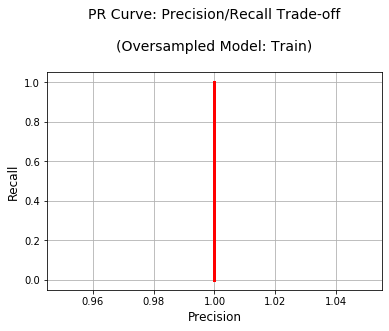

In [24]:
# PR Curve · OV Train
pr_curve_ov(dtmodel_ov, Xsel_trainres, yselrf_trainres, Xsel_test, ysel_test, train=True)

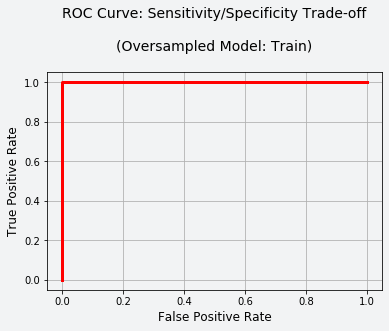

In [25]:
# ROC Curve · OV Train
roc_curve_ov(dtmodel_ov, Xsel_trainres, yselrf_trainres, Xsel_test, ysel_test, train=True)

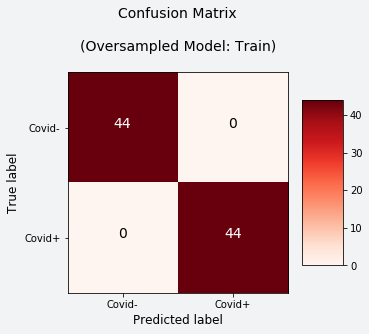

In [26]:
# Confusion matrix · OV Train
conf_matrix_ov(dtmodel_ov, Xsel_trainres, yselrf_trainres, Xsel_test, ysel_test, train=True)

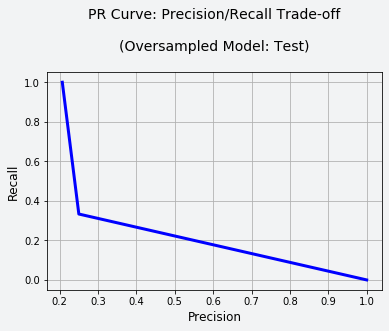

In [27]:
# PR Curve · OV Test
pr_curve_ov(dtmodel_ov, Xsel_trainres, yselrf_trainres, Xsel_test, ysel_test, train=False)

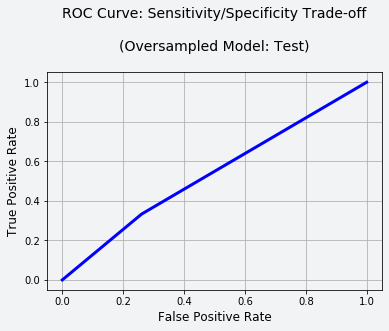

In [28]:
# ROC Curve · OV Test
roc_curve_ov(dtmodel_ov, Xsel_trainres, yselrf_trainres, Xsel_test, ysel_test, train=False)

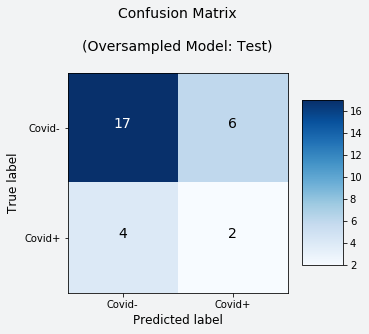

In [29]:
# Confusion matrix · OV Test
conf_matrix_ov(dtmodel_ov, Xsel_trainres, yselrf_trainres, Xsel_test, ysel_test, train=False)

#### Figures: OR model 

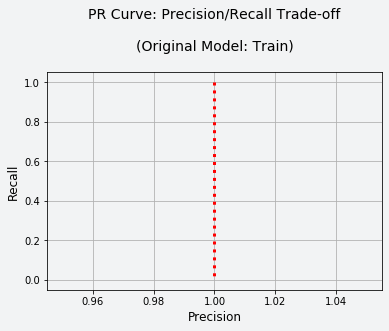

In [30]:
# PR Curve · OR Train
pr_curve_or(dtmodel_or, Xsel_train, yselrf_train, Xsel_test, ysel_test, train=True)

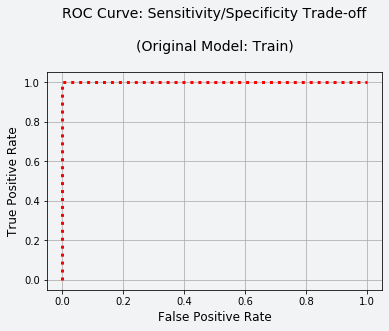

In [31]:
# ROC Curve · OR Train
roc_curve_or(dtmodel_or, Xsel_train, yselrf_train, Xsel_test, ysel_test, train=True)

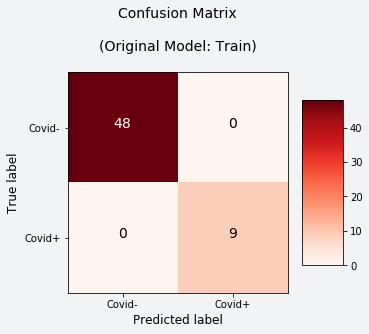

In [32]:
# Confusion matrix · OR Train
conf_matrix_or(dtmodel_or, Xsel_train, yselrf_train, Xsel_test, ysel_test, train=True)

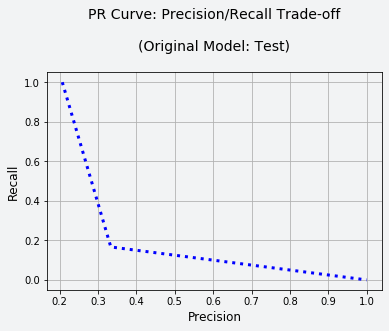

In [33]:
# PR Curve · OR Test
pr_curve_or(dtmodel_or, Xsel_train, yselrf_train, Xsel_test, ysel_test, train=False)

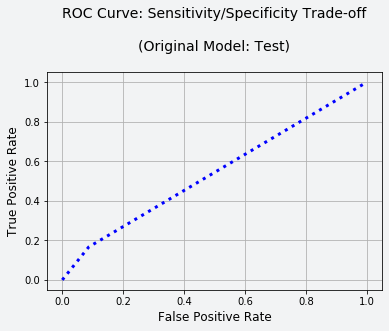

In [34]:
# ROC Curve · OR Test
roc_curve_or(dtmodel_or, Xsel_train, yselrf_train, Xsel_test, ysel_test, train=False)

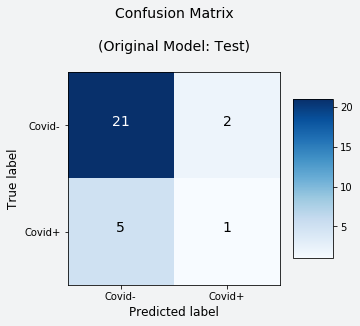

In [35]:
# Confusion matrix · OR Test
conf_matrix_or(dtmodel_or, Xsel_train, yselrf_train, Xsel_test, ysel_test, train=False)

#### Figures: PJ model

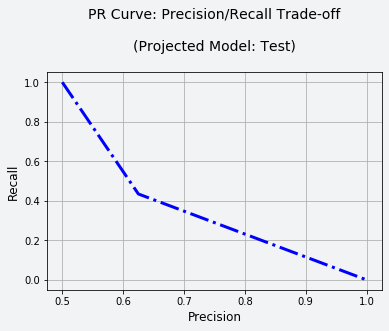

In [36]:
# PR Curve · PJ Test
pr_curve_pj(dtmodel_ov, Xsel_trainres, yselrf_trainres, Xsel_testres, ysel_testres, train=False)

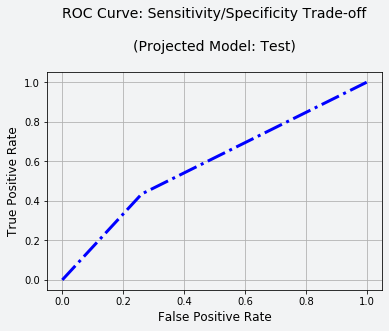

In [37]:
# ROC Curve · PJ Test
roc_curve_pj(dtmodel_ov, Xsel_trainres, yselrf_trainres, Xsel_testres, ysel_testres, train=False)

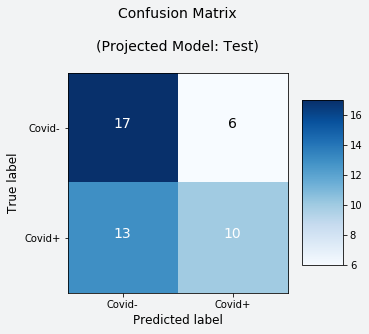

In [38]:
# Confusion matrix · PJ Test
conf_matrix_pj(dtmodel_ov, Xsel_trainres, yselrf_trainres, Xsel_testres, ysel_testres, train=False)

### Predictions

#### OV model

In [39]:
# Predictions on test
dtmodel_ov_classPred = dtmodel_ov.predict(Xsel_test)
print('Classification predictions: \n', dtmodel_ov_classPred)
dtmodel_ov_probPred = dtmodel_ov.predict_proba(Xsel_test)[:, 1]
print('Predictions probabilities: \n', dtmodel_ov_probPred)

Classification predictions: 
 [1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1]
Predictions probabilities: 
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1.]


#### OR model

In [40]:
# Predictions on test
dtmodel_or_classPred = dtmodel_or.predict(Xsel_test)
print('Classification predictions: \n', dtmodel_or_classPred)
dtmodel_or_probPred = dtmodel_or.predict_proba(Xsel_test)[:, 1]
print('Predictions probabilities: \n', dtmodel_or_probPred)

Classification predictions: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1]
Predictions probabilities: 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1.]


#### PJ  model

In [41]:
# Predictions on test
dtmodel_ov_classPred = dtmodel_ov.predict(Xsel_testres)
print('Classification predictions: \n', dtmodel_ov_classPred)
dtmodel_ov_probPred = dtmodel_ov.predict_proba(Xsel_testres)[:, 1]
print('Predictions probabilities: \n', dtmodel_ov_probPred)

Classification predictions: 
 [1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0
 1 1 1 0 0 0 0 0 0]
Predictions probabilities: 
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
